# 0. Introdução

## 0.1 Configurações e Importação das Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import os
import string
import warnings
warnings.filterwarnings('ignore')

colors = ['#003f5c', '#00597b', '#007594', '#0092a3', '#00afa7', '#00cb9f', '#00e68e', '#63ff74']
palette = sns.set_palette(sns.color_palette(colors))
sns.set_theme(style='whitegrid', palette=palette)

SEED = 0

## 0.2 Importando os Dados

In [4]:
cwd = os.getcwd()

df_train = pd.read_csv(f'{cwd}\\train.csv')
df_test = pd.read_csv(f'{cwd}\\test.csv')
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [10]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

# 1. Análise Exploratória Dos Dados

## 1.1 Visão Geral
* `PassengerId` é o id único da linha e não tem nenhum efeito no *target*
* `Survived` é a variável *target* que estamos tentando prever (**0** or **1**):
    - **1 = Sobreviveu**
    - **0 = Não Sobreviveu**
* `Pclass` (Passenger Class) é o status socioeconômico do passageiro e é uma característica categórica que tem **3** valores únicos (**1**,  **2 **or **3**):
    - **1 = Classe Alta**
    - **2 = Classe Média**
    - **3 = Classe Baixa**
* `Name`, `Sex` and `Age` são autoexplicativas
* `SibSp` é o número total de irmão e cônjuges dos passageiros
* `Parch` é o número total de pais e filhos dos passageiros
* `Ticket` é o número do bilhete do passageiro
* `Fare` é a tarifa do passageiro
* `Cabin` é o número da cabine do passageiro
* `Embarked` é o porto de embargue e é uma característica categórica que tem **3** valores únicos (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Aqui na visão geral já da pra ver que temos valores faltantes, vamos dar uma olhada melhor neles:

# 1.2 Valores Faltantes

In [17]:
df_train.isnull().sum() # Valores nulos no DataFrame de treino

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [18]:
df_test.isnull().sum() # Valores nulos do DataFrame de teste

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

É conveniente trabalhar com a concatenação do conjunto de teste e treino, caso contrário, os dados preenchidos podem *overfitar*. A quantidade de valore nulos em `Age`, `Embbarked` e `Fare` são pequenos comparados a amostra total, mas aproximadamente **80%** de `Cabin` estão faltando. Valores faltantes em `Age`, `Embarked` e `Fare` podem ser preenchidos com medidas estatísticas descritivas, mas isso não funcionaria para `Cabin`.

**overfitar** é um termo informal para representar quando ocorre *overfit*. *Overfit* é quando o modelo se acostuma tanto com os dados de treino que ele praticamente 'decora' um resultado, a consequência disso é que ele terá um desempenho excelente no treino, porém quando submetido aos dados de teste o desempenho será ruim. A tradução formal de *overfit* é sobreajuste.

### 1.2.1 Age

Valores faltantes de `Age` podem ser preenchidos com a idade média, porém usando a idade média de todo o conjunto de dados não é uma boa escolha. A melhor escolha seria a idade média dos grupos `Pclass` devido à sua alta correlação com `Age` e `Survived`. Veja a demonstração abaixo:

- `df.corr()` : é usado para encontrar correlações em pares de todas as colunas do DataFrame.
- `abs()` : retorna o valor absoluto de um dado número, ou seja, sua magnitude.
- `unstack()` : retorna um Dataframe com um novo nível de *labels* de coluna cujo nível mais interno consiste nos *labels* de índice dinâmico.
- `sort_values()` : ordena os valores em qualquer um dos eixos.
    - `kind` : parâmetro que permite escolher o algoritmo de ordenação que será utilizado.
    - `ascending` : parâmetro para definir se a ordenação será feita de maneira crescente (True) ou decrescente (False).
- `reset_index()` : reseta os índices.


In [27]:
# Cria um Dataframe com a correlações das variáveis
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
# Muda o nome das colunas do DataFrame
df_all_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation Coefficient'}, inplace=True)
# Seleciona somente as correlações de 'Age'
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Para ser mais preciso, a variável `Sex` é usada como segundo nível de *groupby* enquanto preenche os valores de idade ausentes. Como pode ser visto abaixo, os grupos `Pclass` e `Sex` têm valores medianos distintos. Quando a classe de passageiros aumenta, a idade média para homens e mulheres também aumenta. No entanto, as mulheres tendem a ter uma idade mediana ligeramente inferior à dos homens. As idades medianas abaixo são usadas para preencher os valores ausentes na *feature* `Age`.

In [134]:
# Cria um DataFrame com a mediana das idades por sexo e classe 
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

# Organizando os dados para plotar
data = []
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        data += [{
            'Pclass': pclass,
            'median_age': age_by_pclass_sex[sex][pclass],
            'sex': sex 
        }]

# DataFrame para plotar o gráfico
age_by_pclass_sex = pd.DataFrame(data)


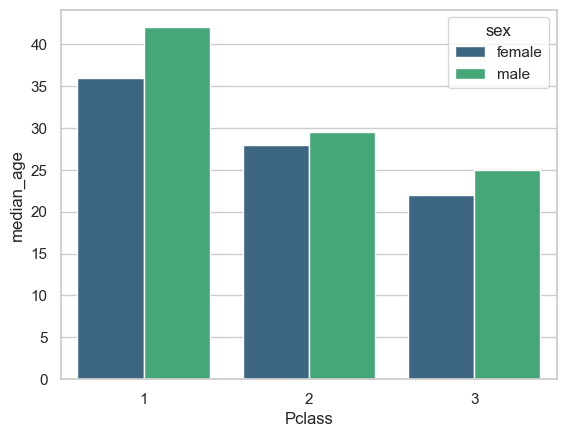

In [135]:
sns.barplot(x=age_by_pclass_sex['Pclass'], y=age_by_pclass_sex['median_age'], hue='sex', data=age_by_pclass_sex, palette='viridis');

Feito essa análise, vamos preencher os valores ausentes de `Age` com a mediana dos grupos `Sex` e `Pclass`

In [136]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### 1.2.2 Embarked
`Embarked` é uma *feature* categórica e só possui **2** valores ausentes. Ambos passageiros são mulheres, classe alta e possuem o mesmo número de bilhete. Isso significa que elas se conhecem e embarcaram juntas no mesmo porto. Vamos ver qual porto mais passageiros com essas características embarcaram:

In [151]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [149]:
df_all.query("Sex == 'female' and Pclass == 1")['Embarked'].value_counts(ascending=False)

C    71
S    69
Q     2
Name: Embarked, dtype: int64

O porto que embarcou mais passageiros com essas características foi o de *Cherbourg*, entretando com um valor muito próximo do porto de *Southampton*. Feito essa análise eu vou ir mais a fundo sobre essa informação para deixar aqui registrado uma mensagem muito importante para mim...

Pesquisando os valores do salário líquido mensal médio (após impostos) de *Cherbourg* e *Southampton* que possuem números de passageiros embarcados bem próximos, encontrei:
- **Cherbourg:** $1.875,74
- **Southampton:** $2.679,46


Com base nisso, eu poderia pensar que a *Mrs. George Nelson* embarcou no porto de *Southampton* pelo fato de que o salário médio é maior e ela embarcou na classe alta.

Para tirar a prova dessa suposição, pesquisei o nome dela no google e veja o que eu encontrei:
> *'Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.'*
Informação encontrada nessa página, [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)